In [13]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner

starry.config.quiet = True
np.random.seed(1)

## Helper functions

In [14]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [15]:
def generate(t, params, seed=1, error=1e-3, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, m=params["star.m"]["truth"]) # *** maybe also `r`
    planet = starry.Secondary(
        starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    
    # Get the flux design matrix
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    A = map.design_matrix(
        theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]
    ).eval()
    print(A.shape)
    
    # *** Draw 1 sample from the GP
    np.random.seed(seed)
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )
    y = sp.sample_ylm().eval().reshape(-1)

    # Starry process Ylms are normalized so that they have
    # zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
    # Let's renormalize it to unity, since that's the baseline
    # we want for transits
    y[0] += 1
    
    # Compute the light curve
    flux0 = A @ y
    
    # Add photometric noise
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    noise = np.random.randn(len(t)) * err
    flux += noise
    
    # *** Normalize the flux
    params["gp.norm"]["truth"] = np.median(flux)
    med_flux = np.median(flux)
    flux /= med_flux 
    # flux /= params["gp.norm"]["truth"]
    err /= med_flux
    # err /= params["gp.norm"]["truth"]
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux, err, med_flux

In [16]:
def bin_out_of_transit(t, flux, err, params, dt=0.1, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

In [17]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        # Instantiate the system
        map = starry.Map(15, 2)
        map.inc = parameter("star.inc")
        map[1] = parameter("star.u1")
        map[2] = parameter("star.u2")
        star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
        planet = starry.Secondary(
            starry.Map(),
            inc=parameter("planet.inc"),
            ecc=parameter("planet.ecc"),
            Omega=parameter("planet.Omega"),
            w=parameter("planet.w"),
            porb=parameter("planet.porb"),
            t0=parameter("planet.t0"),
        )
        sys = starry.System(star, planet)
        xo, yo, zo = sys.position(t)

        # Get the flux design matrix
        theta = (360 * t / parameter("star.prot")) % 360
        A = map.design_matrix(
            theta=theta,
            xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
            yo=yo[1],
            zo=zo[1],
            ro=parameter("planet.r"),
        )

        # Instantiate the GP
        # sigma = pm.Uniform("sigma", 1.0, 10.0)
        sp = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            # sigma=sigma,
            r=parameter("gp.r"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            marginalize_over_inclination=False,  # *** we know the inclination
            normalized=False,  # *** we're modeling the normalization explicitly
        )
        norm = parameter("gp.norm")

        # Compute the flux covariance
        # cov_ylm = sp.cov_ylmx
        # cov_flux = tt.dot(tt.dot(A, cov_ylm), tt.transpose(A))
        # cov_flux += tt.diag(err * norm) ** 2

        # Compute the flux mean; remember to offset Y_{0,0} by one
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm)

        # Marginal likelihood
        # *** I can't tell if the expression using the Woodbury identity was
        # correct. It's tempting to optimize the math along the way, but I think
        # it's more important to keep things simple for now so we can debug. Optimize
        # for speed at the end; then you can compare your optimized likelihood to this
        # value, which you'll have as a benchmark.
        # pm.MvNormal("marginal", mu=mu_flux, cov=cov_flux, observed=flux * norm)

        # Compute the log likelihood
        # Cov matrix at the ylm basis
        Sigma_s = sp.cov_ylm

        # err *= norm # Rodrigo
    
        

        # Compute the marginal likelihood
        U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))
        log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
        K = len(t)
        mean = norm*mu_flux # Will
        # mean = mu_flux # Rodrigo
        # mean = mu_flux/norm # Sabina
        # r = tt.as_tensor_variable(flux*norm) - mean # Rodrigo
        r = tt.as_tensor_variable(flux) - mean  # Will
        v = tt.dot(A.T,(r/tt.square(err)))
        Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))
        loglike = -0.5 * Q#*tt.square(norm) # Rodrigo (Sabina)
        loglike -= 0.5  * log_sigmadet
        loglike -= 0.5 * K * tt.log(2 * np.pi)

        pm.Potential("lnlike", loglike)

        return model

## Generate a light curve

In [19]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 88.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.0, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 100, "dist": Angle},
    "planet.w": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 1.0, "dist": Uniform, "args": [0.975, 1.025]},
    "planet.t0": {"truth": 0.5, "dist": Uniform, "args": [0.475, 0.525]},
    "planet.r": {"truth": 0.1, "dist": Uniform, "args": [0.09, 0.11]},
    "star.inc": {"truth": 90, "dist": Inclination},
    "star.m": {"truth": 0.5, "dist": Uniform, "args": [0.4, 0.6]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 0.34, "dist": pm.Uniform, "args": [0.1, 1.0]},
    "gp.r": {"truth": 10, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.c": {"truth": 0.1, "dist": Uniform, "args": [0.01, 0.5]},
    "gp.n": {"truth": 20, "dist": Uniform, "args": [1, 30]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]},
    "gp.norm": {"truth": 1, "dist": Uniform, "args": [0.5, 1.5]}
}

# *** Time array (1 day @ 2 min cadence)
t = np.arange(0, 1, 2 / 24 / 60)

# Get the light curve
flux, err, med_flux = generate(t, params, error=1e-4)
# params['gp.norm']['truth'] = med_flux

# Get the binned light curve
t_, flux_, err_ = bin_out_of_transit(t, flux, err, params, dt=0.2)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux, "C1.", alpha=0.3, label="full")
ax.plot(t_, flux_, "k.", label="binned")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: InplaceDimShuffle{x,x}(TensorConstant{0.0})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/theano/tensor/opt.py", line 7006, in constant_folding
    thunk = node.op.make_thunk(
  File "/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/theano/graph/op.py", line 634, in make_thunk
    return self.make_c_thunk(node, storage_map, compute_map, no_recycling)
  File "/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/theano/graph/op.py", line 600, in 

KeyboardInterrupt: 

In [84]:
params['gp.norm']['truth'] = 1

# Inference

In [63]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.mu"]["testval"] = 30
#p["gp.norm"]["free"] = True
#p["gp.norm"]["testval"] = 1
model = gp_model(t, flux, err, p)

# Optimize
free = [x for x in p.keys() if p[x].get("free", False)]
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")
        p[x]["free"] = False

optimizing logp for variables: [gp.mu]



gp.mu: 42.69043529455448 [30]


message: Desired error not necessarily achieved due to precision loss.
logp: 2728.3646151252015 -> 4033.2180502408382


In [64]:
# Set some free params & get the model
p = dict(params).copy()
p["gp.mu"]["free"] = True
p["gp.mu"]["testval"] = 30
p["gp.norm"]["free"] = True
p["gp.norm"]["testval"] = 1
# p["gp.sigma"]["free"] = True
# p["gp.sigma"]["testval"] = 0.5
# p["gp.n"]["free"] = True
# p['gp.c']['free'] = True
# p['gp.r']['free'] = True
model = gp_model(t, flux, err, p)

# Optimize
free = [x for x in p.keys() if p[x].get("free", False)]
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")
        # p[x]["free"] = False

optimizing logp for variables: [gp.norm, gp.mu]



gp.mu: 29.817707189615682 [30]
gp.norm: 0.9462140588615242 [1]


message: Desired error not necessarily achieved due to precision loss.
logp: 2726.9783207640817 -> 5489.70012960354


In [65]:
# Set some free params & get the model
p = dict(params).copy()
p["gp.mu"]["free"] = True
p["gp.mu"]["testval"] = 30
p["gp.norm"]["free"] = True
p["gp.norm"]["testval"] = 1
p["gp.sigma"]["free"] = True
p["gp.sigma"]["testval"] = 5
# p["gp.n"]["free"] = True
# p['gp.c']['free'] = True
# p['gp.r']['free'] = True
model = gp_model(t, flux, err, p)

# Optimize
free = [x for x in p.keys() if p[x].get("free", False)]
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")
        # p[x]["free"] = False

optimizing logp for variables: [gp.norm, gp.sigma, gp.mu]



gp.mu: 30.03399518673138 [30]
gp.sigma: 5.08200419930644 [5]
gp.norm: 0.9463424479513416 [1]


message: Desired error not necessarily achieved due to precision loss.
logp: 2725.579603882963 -> 5488.2541512889175


In [66]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.mu"]["testval"] = 30
p["gp.norm"]["free"] = True
p["gp.norm"]["testval"] = 1
p["gp.sigma"]["free"] = True
p["gp.sigma"]["testval"] = 5
p["gp.n"]["free"] = True
p["gp.n"]["testval"] = 20
p['gp.c']['free'] = True
p['gp.c']['testval'] = 0.1
# p['gp.r']['free'] = True
model = gp_model(t, flux, err, p)

# Optimize
free = [x for x in p.keys() if p[x].get("free", False)]
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")
        # p[x]["free"] = False

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.sigma, gp.mu]



gp.c: 0.08662333988281767 [0.1]
gp.n: 24.28685735899316 [20]
gp.mu: 30.332995987692847 [30]
gp.sigma: 5.3945524324356215 [5]
gp.norm: 0.9440339265872704 [1]


message: Desired error not necessarily achieved due to precision loss.
logp: 2722.194499788555 -> 5485.414436625135


In [90]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.mu"]["testval"] = 30
p["gp.norm"]["free"] = True
p["gp.norm"]["testval"] = 1
p["gp.sigma"]["free"] = True
p["gp.sigma"]["testval"] = 5
p["gp.n"]["free"] = True
p["gp.n"]["testval"] = 20
p['gp.c']['free'] = True
p['gp.c']['testval'] = 0.1
p['gp.r']['free'] = True
p['gp.r']['testval'] = 10
model = gp_model(t, flux, err, p)

# Optimize
free = [x for x in p.keys() if p[x].get("free", False)]
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")
        # p[x]["free"] = False

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]



gp.r: 10.562173106004934 [10]
gp.c: 0.09805968846982287 [0.1]
gp.n: 16.627251970080927 [20]
gp.mu: 28.516712718083536 [30]
gp.sigma: 3.6649304787598314 [5]
gp.norm: 1.0524897312583996 [0.9465594370762206]


message: Desired error not necessarily achieved due to precision loss.
logp: 2720.5205233549827 -> 5447.882354062823


Posterior sampling with `pymc3` is super slow for this problem. Try using the `MCMCSampler` described [here](https://starry-process.readthedocs.io/en/latest/notebooks/Ensemble/).

Sequential sampling (4 chains in 1 job)
NUTS: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


Sampling 4 chains for 250 tune and 500 draw iterations (1_000 + 2_000 draws total) took 52477 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7855511641646644, but should be close to 0.9. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


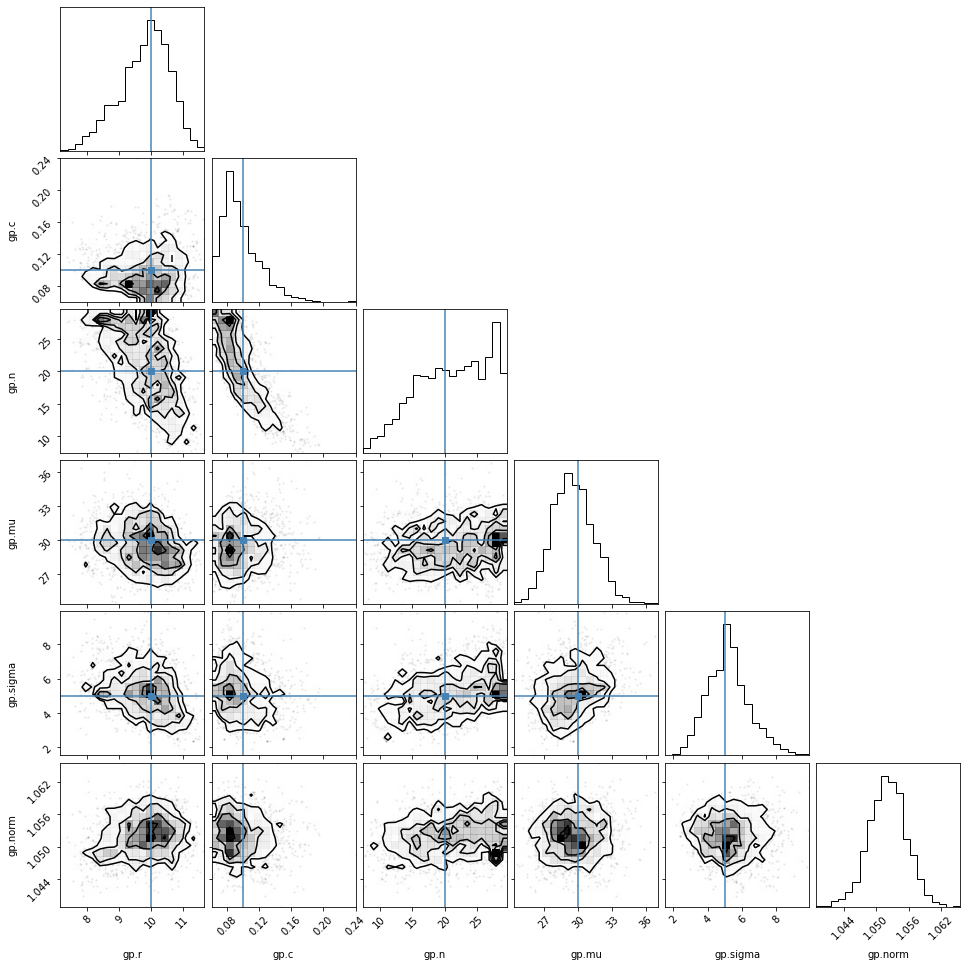

In [14]:
# Sample
with model:
    trace = pmx.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        target_accept=0.9,
        return_inferencedata=False,
    )

# Plot
samples = pm.trace_to_dataframe(trace, varnames=free)
corner(np.array(samples), labels=free, truths=[params[x]["truth"] for x in free]);

In [15]:
samples['gp.norm']

0       1.057610
1       1.054312
2       1.054300
3       1.051391
4       1.051179
          ...   
1995    1.054569
1996    1.050998
1997    1.051830
1998    1.052774
1999    1.051760
Name: gp.norm, Length: 2000, dtype: float64

In [17]:
import arviz as az
az.summary(trace, var_names=free)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gp.r,9.792,0.783,8.256,11.134,0.052,0.037,249.0,479.0,1.01
gp.c,0.096,0.023,0.061,0.139,0.002,0.001,116.0,87.0,1.05
gp.n,21.168,5.353,12.034,29.011,0.721,0.565,40.0,58.0,1.08
gp.mu,29.548,1.825,26.124,32.795,0.063,0.045,861.0,1169.0,1.01
gp.sigma,5.221,1.244,3.063,7.732,0.058,0.043,469.0,504.0,1.02
gp.norm,1.052,0.003,1.046,1.059,0.000,0.000,752.0,1005.0,1.01


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'gp.r'}>,
        <AxesSubplot:title={'center':'gp.r'}>],
       [<AxesSubplot:title={'center':'gp.c'}>,
        <AxesSubplot:title={'center':'gp.c'}>],
       [<AxesSubplot:title={'center':'gp.n'}>,
        <AxesSubplot:title={'center':'gp.n'}>],
       [<AxesSubplot:title={'center':'gp.mu'}>,
        <AxesSubplot:title={'center':'gp.mu'}>],
       [<AxesSubplot:title={'center':'gp.sigma'}>,
        <AxesSubplot:title={'center':'gp.sigma'}>],
       [<AxesSubplot:title={'center':'gp.norm'}>,
        <AxesSubplot:title={'center':'gp.norm'}>]], dtype=object)

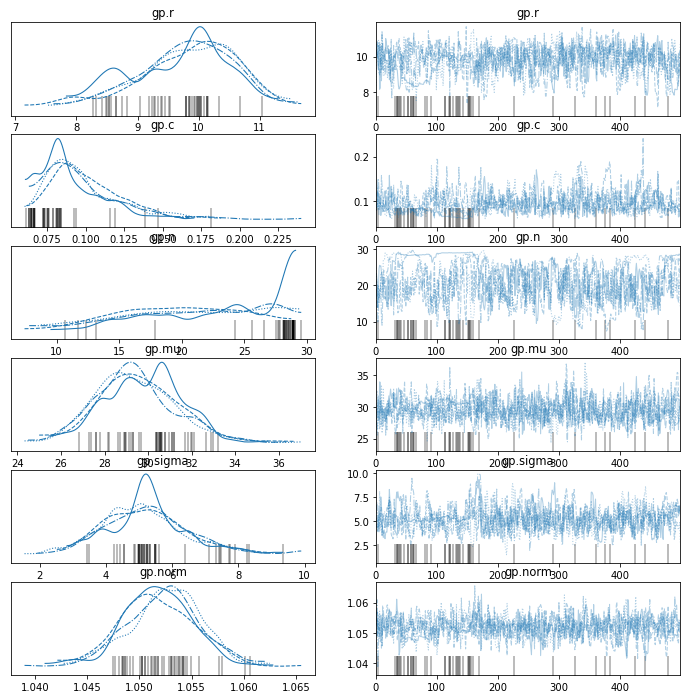

In [18]:
az.plot_trace(trace,var_names=free)

In [19]:
az.from_pymc3(trace);
az.to_netcdf(trace,'file1.nc');

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


In [20]:
az_trace=az.from_netcdf('file1.nc')

# Trying another sampler

In [91]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [92]:
x = mci.optimize()

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: 2720.5205233549827 -> 5447.882354062823


In [93]:
mci.transform(x, varnames=free)

  0%|          | 0/1 [00:00<?, ?it/s]

array([10.56217311,  0.09805969, 16.62725197, 28.51671272,  3.66493048,
        1.05248973])

In [94]:
nwalkers = 30
p0 = mci.get_initial_state(nwalkers)

In [95]:
mci.logp(x)

array(5447.88235406)

In [96]:
import emcee

# Number of parameters
ndim = p0.shape[1]

# Instantiate the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)

# Run the chains
np.random.seed(0)
nsteps = 500
_ = sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 500/500 [18:21<00:00,  2.20s/it]


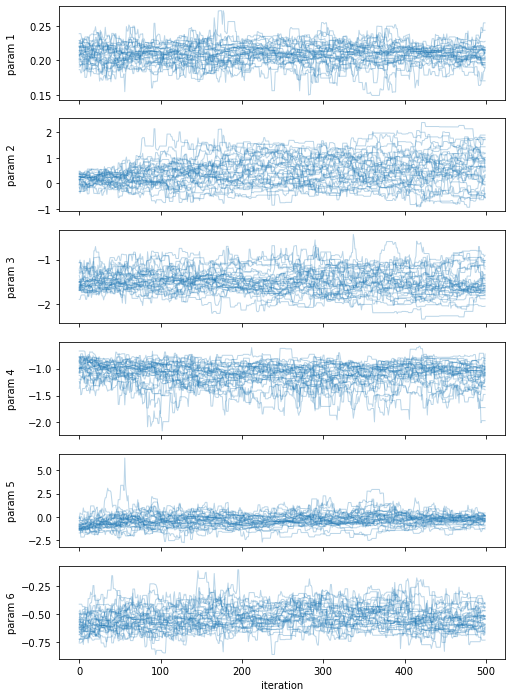

In [97]:
# Plot the walkers
fig, ax = plt.subplots(ndim, figsize=(8, 12), sharex=True)
for j in range(ndim):
    for k in range(nwalkers):
        ax[j].plot(sampler.chain[k, :, j], "C0-", lw=1, alpha=0.3)
    ax[j].set_ylabel("param {}".format(j + 1))
ax[-1].set_xlabel("iteration")
fig.align_ylabels(ax)
plt.show()

In [98]:
burnin = 200
samples = sampler.chain[:, burnin:, :].reshape(-1, ndim)

In [99]:
samples = mci.transform(samples, varnames=free)

  0%|          | 0/9000 [00:00<?, ?it/s]

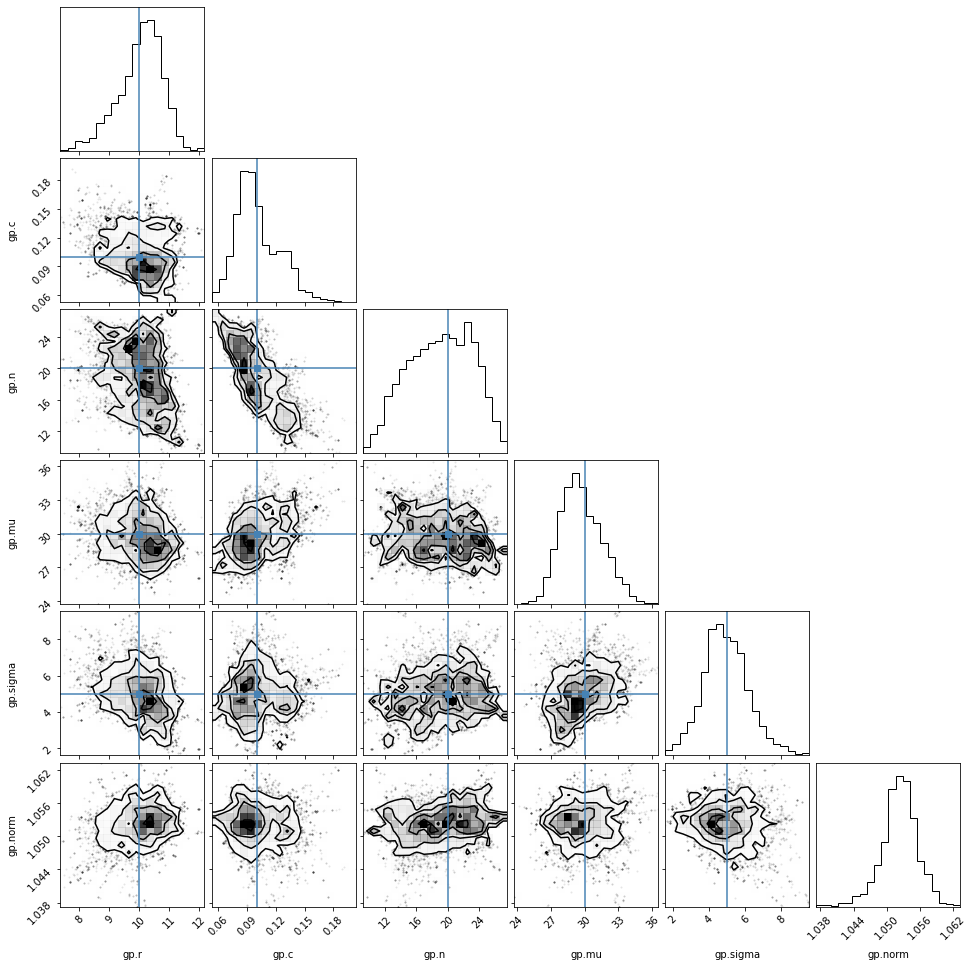

In [101]:
corner(np.array(samples), labels=free, truths=[params[x]["truth"] for x in free]);